In [1]:
# --- 0. IMPORTS ---
import pandas as pd
import scanpy as sc
import anndata as ad
import os
import hdf5plugin 
import numpy as np

main_path = r"Z:\selim_working_dir\2023_nr4a1_colon\results"
os.chdir(main_path)

adata = sc.read_h5ad("sce_data_2023_nr4a1_colon_AmbientRNARemoved_FixedKOvsWT_SubAnnotated4.h5ad")

adata

AnnData object with n_obs × n_vars = 110348 × 16149
    obs: 'cell_type', 'batch_id', 'cluster', 'BatchID0', 'CellType0', 'Condition', 'SubCellType'
    obsm: 'X_umap'


**Re-running Normalization and Analysis** on combined raw data...
PCA analysis in chunks of 10000 cells (n_comps=50)...
Computing nearest neighbors (k=15) and UMAP (n_dims=2)...

Computing **Global** Leiden clusters (res=1.0, flavor=leidenalg) on all 110348 cells...


C:\Users\ssromerogon\AppData\Local\Temp\ipykernel_22132\3124373260.py:44: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


Global Leiden clustering complete. Results in adata.obs['leiden_global_1.0']

Plotting UMAP colored by leiden_global_1.0 and saving...


<Axes: title={'center': 'leiden_global_1.0'}, xlabel='UMAP1', ylabel='UMAP2'>

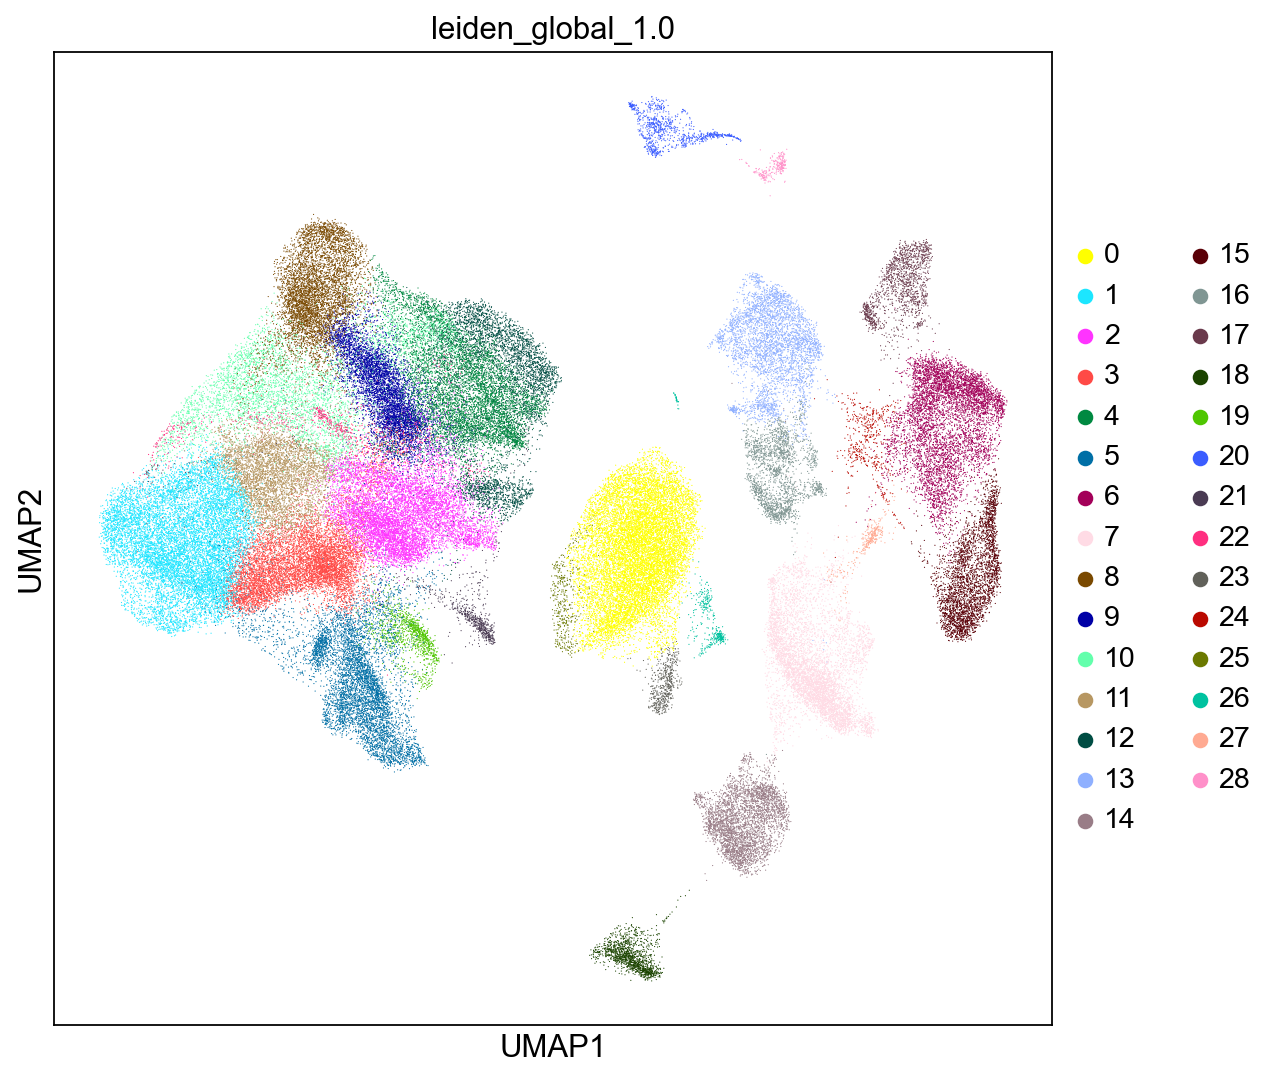

In [2]:
# Make a clean copy of counts
adata.layers["counts"] = adata.X.copy()

# --- Post-merging Analysis (Re-run embeddings on combined data) ---
# Now we must re-run normalization, as adata.X contains raw counts.
print("\n**Re-running Normalization and Analysis** on combined raw data...")

# 3.1 Re-Normalize and Log-Transform
# This overwrites adata.X with the normalized, log-transformed data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="batch_id")# Flavor seurat

# 4. PCA (Step 7)
# Use 'highly_variable' genes determined during initial per-sample QC
npca = 50

use_hvg = adata.var['highly_variable'].sum() > 0
if adata.n_obs > 20000:
    print(f"PCA analysis in chunks of 10000 cells (n_comps={npca})...")
    sc.tl.pca(adata, n_comps=npca, mask_var="highly_variable", chunked=True, chunk_size=10000, svd_solver="arpack")
else:
    print(f"PCA analysis (n_comps={npca})...")
    sc.tl.pca(adata, n_comps=npca, mask_var="highly_variable", chunked=False, svd_solver="arpack")
 
 # --- Custom Parameters ---
ndim = 2           # Number of UMAP dimensions
n_neighbors = 15   # Number of neighbors for the graph
my_res = 1.0       # Clustering resolution (changed from 2.0 to 1.0 as requested)
algo_cluster = "leidenalg"

# 5. Neighbors and UMAP (Step 8)
# This step uses the 50-component PCA result (adata.obsm['X_pca'])
print(f"Computing nearest neighbors (k={n_neighbors}) and UMAP (n_dims={ndim})...")
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=npca)
sc.tl.umap(adata, n_components=ndim)

# 6. Global Leiden Clustering (Replacing Batch-Aware Clustering)
# This runs Leiden once on the entire graph structure computed from the 50 PCs.
cluster_key = f'leiden_global_{my_res}' # Renamed key to reflect global clustering
print(f"\nComputing **Global** Leiden clusters (res={my_res}, flavor={algo_cluster}) on all {adata.n_obs} cells...")

sc.tl.leiden(
    adata,
    flavor=algo_cluster,
    n_iterations=2, # Use n_iterations=2 as in the previous code
    resolution=my_res,
    key_added=cluster_key
)

print(f"Global Leiden clustering complete. Results in adata.obs['{cluster_key}']")

# 7. Plot and Save UMAP
print(f"\nPlotting UMAP colored by {cluster_key} and saving...")
sc.set_figure_params(figsize=(8, 8)) 
sc.pl.umap(adata, color=[cluster_key, ], show=False)
# The final H5AD save (Step 8) will automatically include all new results.

[<Axes: title={'center': 'leiden_global_1.0'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'CellType0'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'SubCellType'}, xlabel='UMAP1', ylabel='UMAP2'>]

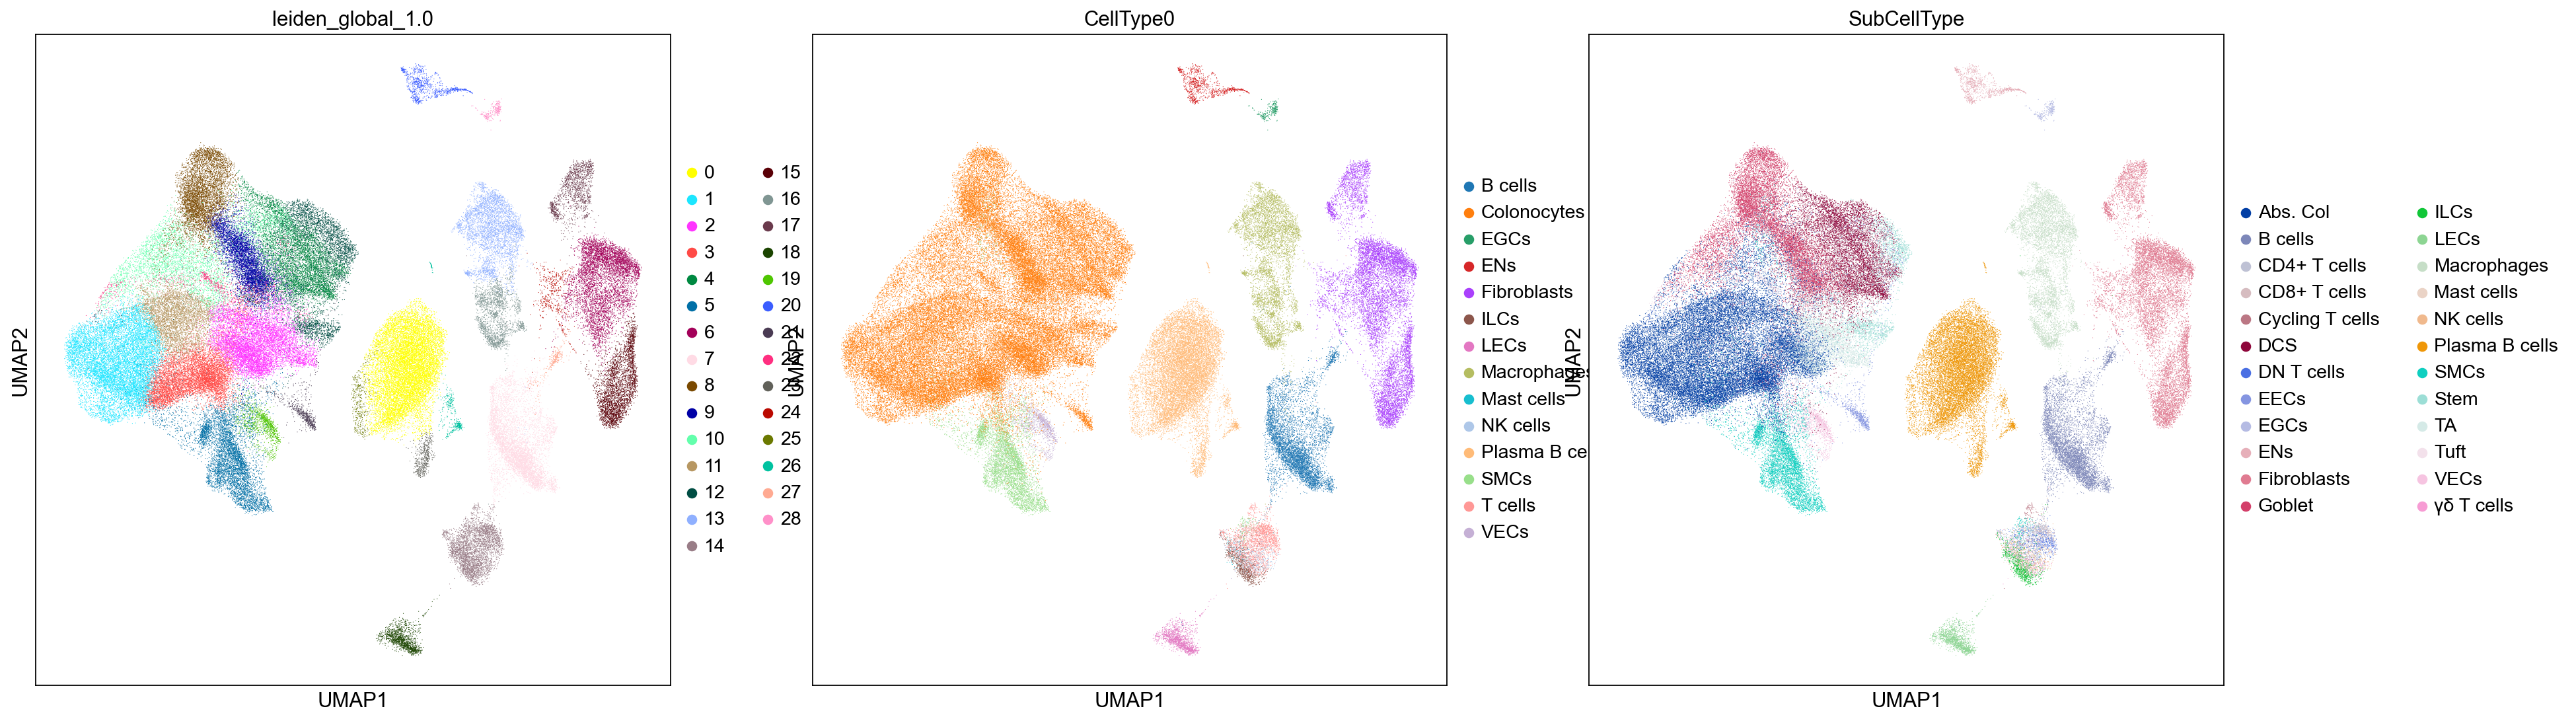

In [5]:
sc.pl.umap(adata, color=[cluster_key, 'CellType0', 'SubCellType'], show=False)

In [6]:
adata

AnnData object with n_obs × n_vars = 110348 × 16149
    obs: 'cell_type', 'batch_id', 'cluster', 'BatchID0', 'CellType0', 'Condition', 'SubCellType', 'leiden_global_1.0'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden_global_1.0', 'leiden_global_1.0_colors', 'CellType0_colors', 'SubCellType_colors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [8]:
# --- 0. IMPORTS ---
import pandas as pd
import scanpy as sc
import anndata as ad
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION AND PREPARATION ---
# Assume 'adata' is your pre-existing, loaded AnnData object.
# Example: adata = sc.read_h5ad("C:\\path\\to\\your\\processed_adata.h5ad")
# Define file paths
raw_data_dir = r"Z:\selim_working_dir\2023_nr4a1_colon\h5_files_pools_1_2"

# -----------------------------------------
# HAND-WRITTEN MAPPING OF PROBE IDs TO EXONS
exon_mapping = {
    'Nr4a1|03c248a': 'Exon 7',
    'Nr4a1|99a0eaa': 'Exon 5 (KO Target)',
    'Nr4a1|dbf6af3': 'Exon 3 (KO Target)'
}
nr4a1_probe_ids = list(exon_mapping.keys())
print(f"Using these probe IDs: {nr4a1_probe_ids}")
# -----------------------------------------

# --- Step 1: Create the 'BatchID0' shopping list ---
print("--- Step 1: Creating a 'shopping list' of target cells from your adata object ---")
# Group cells by full BatchID0 (e.g. WT-1332, NR4A1-KO-680) for maximum detail:
target_cells_by_batchid = adata.obs.groupby('BatchID0').apply(lambda group: group.index.tolist()).to_dict()
print(f"Found {adata.n_obs} target cells across {len(target_cells_by_batchid)} BatchID0 groups.")

# --- 2. EXTRACT RAW DATA AND PREPARE FOR PLOTTING ---
print("\n--- Step 2: Extracting raw data and preparing for plotting ---")
list_of_dfs = []
for batchid, target_barcodes in target_cells_by_batchid.items():
    # Get the sample numeric id for file location:
    # E.g. WT-1332 --> 1332
    sample_part = str(batchid).split('-')[-1]
    h5_path = os.path.join(raw_data_dir, sample_part, "sample_raw_probe_bc_matrix.h5")
    if os.path.exists(h5_path):
        print(f"Processing BatchID0 {batchid} (file sample part {sample_part})...")
        adata_raw_sample = sc.read_10x_h5(h5_path)
        barcodes_to_extract = adata_raw_sample.obs.index.intersection(target_barcodes)
        # LIMIT TO ONLY YOUR PROBES OF INTEREST!
        df_sample = adata_raw_sample[barcodes_to_extract, nr4a1_probe_ids].to_df()
        # Add both sample_part and full batchid as columns!
        df_sample['sample_id'] = sample_part
        df_sample['BatchID0'] = batchid
        list_of_dfs.append(df_sample)
        print(f"  -> Extracted expression for {len(df_sample)} cells.")
    else:
        print(f"Warning: H5 file not found for sample {sample_part} ({batchid}). Skipping.")

# Concatenate all the small DataFrames into one
if not list_of_dfs:
    raise RuntimeError("No data extracted. Check input files and sample ids.")
final_df = pd.concat(list_of_dfs)

# Melt for long-form plotting, keep full BatchID0
df_long = final_df.melt(
    id_vars=['sample_id','BatchID0'],
    value_vars=nr4a1_probe_ids,
    var_name='probe_id',
    value_name='expression'
)

# Add a 'condition' column (WT vs KO) based on BatchID0
def parse_condition(batchid0):
    batchid0 = str(batchid0)
    if batchid0.startswith('WT'):
        return 'WT'
    elif 'KO' in batchid0:
        return 'KO'
    else:
        return 'Unknown'

df_long['condition'] = df_long['BatchID0'].apply(parse_condition)

print("Data prepared successfully for plotting.")

# (OPTIONAL) Check it looks right:
print(df_long.head())

Using these probe IDs: ['Nr4a1|03c248a', 'Nr4a1|99a0eaa', 'Nr4a1|dbf6af3']
--- Step 1: Creating a 'shopping list' of target cells from your adata object ---
Found 110348 target cells across 8 BatchID0 groups.

--- Step 2: Extracting raw data and preparing for plotting ---
Processing BatchID0 NR4A1-KO-372 (file sample part 372)...


C:\Users\ssromerogon\AppData\Local\Temp\ipykernel_22132\187816684.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  target_cells_by_batchid = adata.obs.groupby('BatchID0').apply(lambda group: group.index.tolist()).to_dict()
C:\Users\ssromerogon\AppData\Local\Temp\ipykernel_22132\187816684.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  target_cells_by_batchid = adata.obs.groupby('BatchID0').apply(lambda group: group.index.tolist()).to_dict()


  -> Extracted expression for 14976 cells.
Processing BatchID0 NR4A1-KO-374 (file sample part 374)...
  -> Extracted expression for 13025 cells.
Processing BatchID0 NR4A1-KO-376 (file sample part 376)...
  -> Extracted expression for 2877 cells.
Processing BatchID0 NR4A1-KO-380 (file sample part 380)...
  -> Extracted expression for 19158 cells.
Processing BatchID0 WT-1332 (file sample part 1332)...
  -> Extracted expression for 15807 cells.
Processing BatchID0 WT-1353 (file sample part 1353)...
  -> Extracted expression for 13147 cells.
Processing BatchID0 WT-1355 (file sample part 1355)...
  -> Extracted expression for 13955 cells.
Processing BatchID0 WT-1362 (file sample part 1362)...
  -> Extracted expression for 16245 cells.
Data prepared successfully for plotting.
  sample_id      BatchID0       probe_id  expression condition
0       372  NR4A1-KO-372  Nr4a1|03c248a         0.0        KO
1       372  NR4A1-KO-372  Nr4a1|03c248a         0.0        KO
2       372  NR4A1-KO-372  Nr4

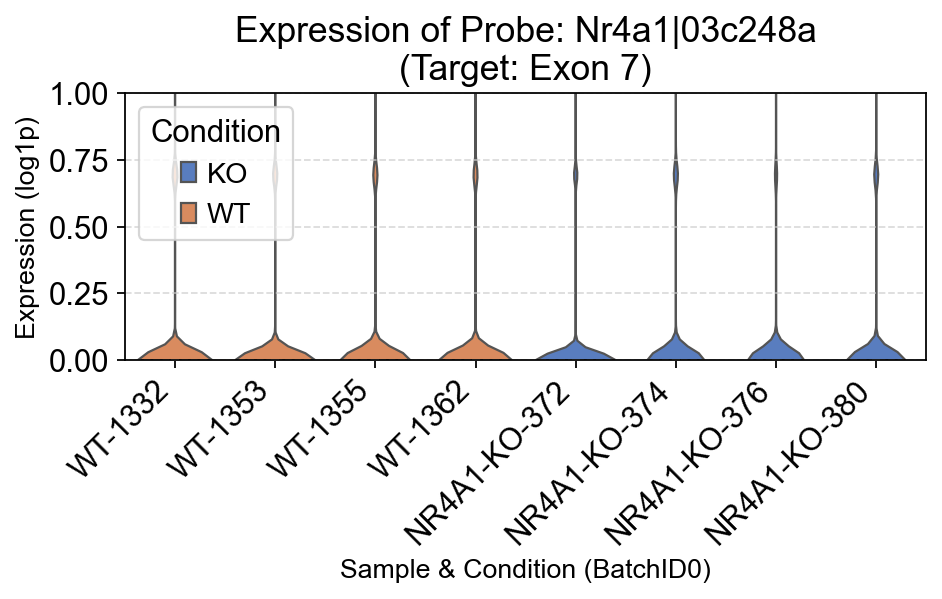

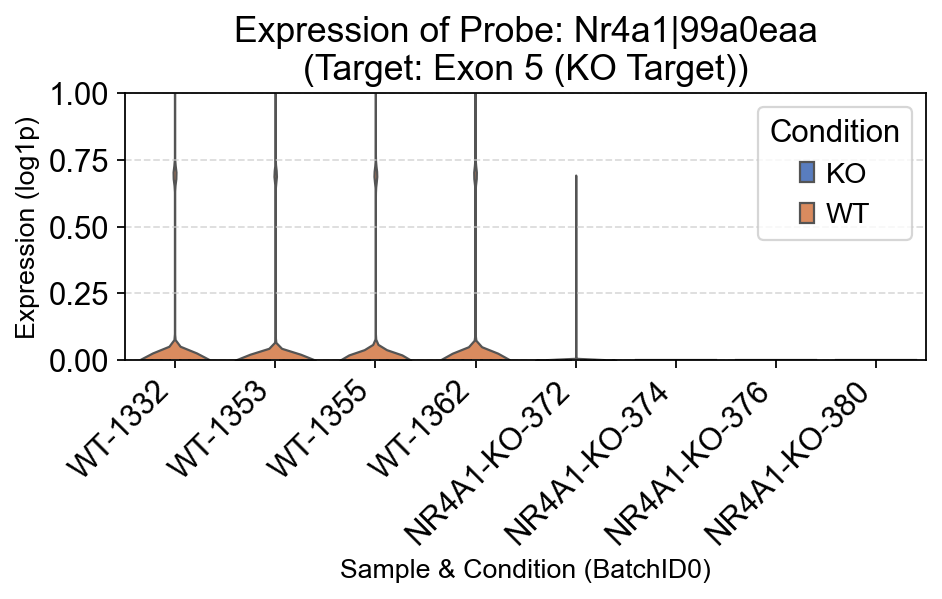

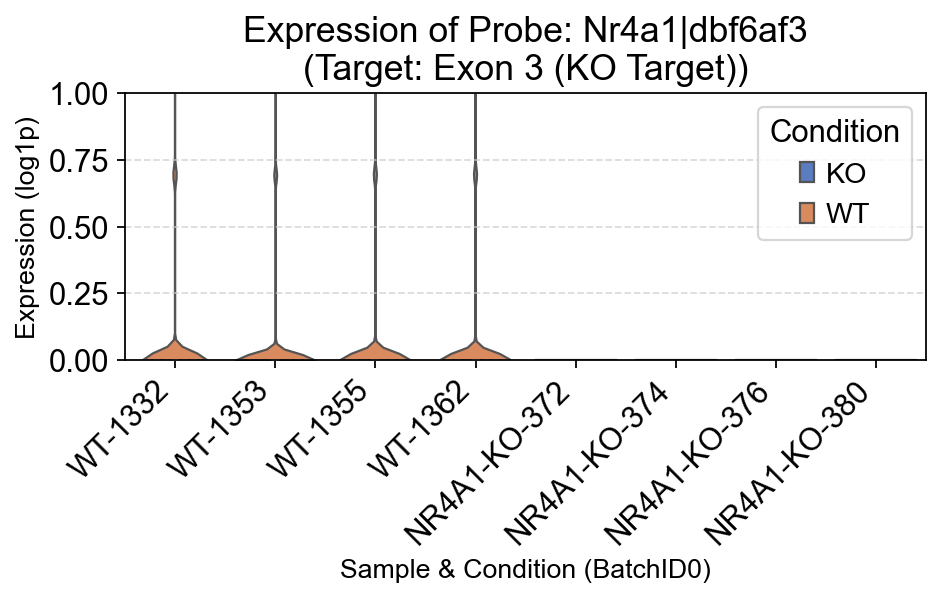

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sample order: so plots are WT then KO, each numerically sorted
def batch_sortkey(bid):
    # E.g. WT-1332 or NR4A1-KO-380
    bid = str(bid)
    cond = bid.split('-')[0]
    sid = int(bid.split('-')[-1])
    cond_order = 0 if 'WT' in cond else 1
    return (cond_order, sid)

batchid0_order = sorted(df_long['BatchID0'].unique(), key=batch_sortkey)

for probe_id in nr4a1_probe_ids:
    plt.figure(figsize=(6, 4))  # <-- reduced size
    df_plot = df_long[df_long['probe_id'] == probe_id].copy()
    df_plot['log1p_expression'] = np.log1p(df_plot['expression'])
    sns.violinplot(
        data=df_plot,
        x='BatchID0',
        y='log1p_expression',
        hue='condition',
        order=batchid0_order,
        cut=0,
        inner='box',
        linewidth=1,
        palette='muted'
    )
    biological_meaning = exon_mapping.get(probe_id, "Unknown Exon")
    plt.title(f"Expression of Probe: {probe_id}\n(Target: {biological_meaning})", fontsize=16)
    plt.xlabel("Sample & Condition (BatchID0)", fontsize=12)
    plt.ylabel("Expression (log1p)", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.legend(title='Condition')
    plt.savefig(f'exon_analysis_{biological_meaning}.svg')
    plt.show()

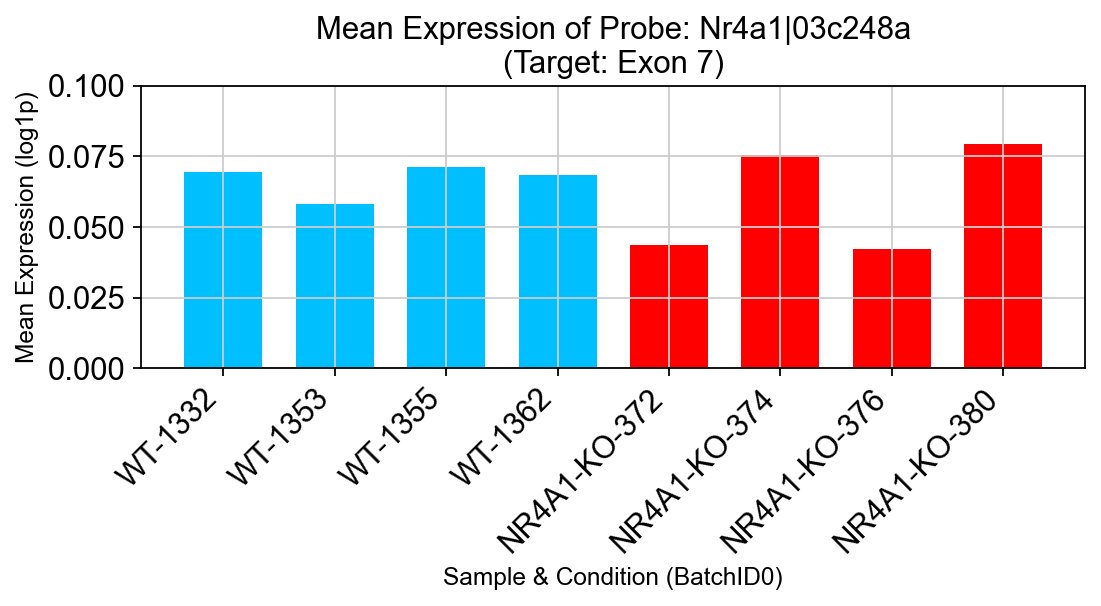

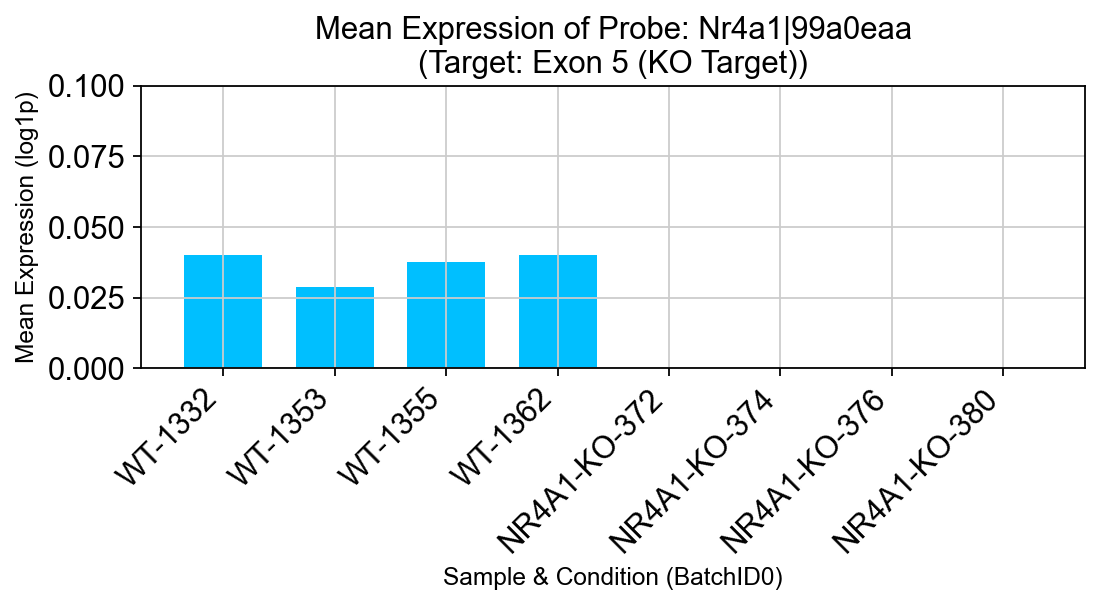

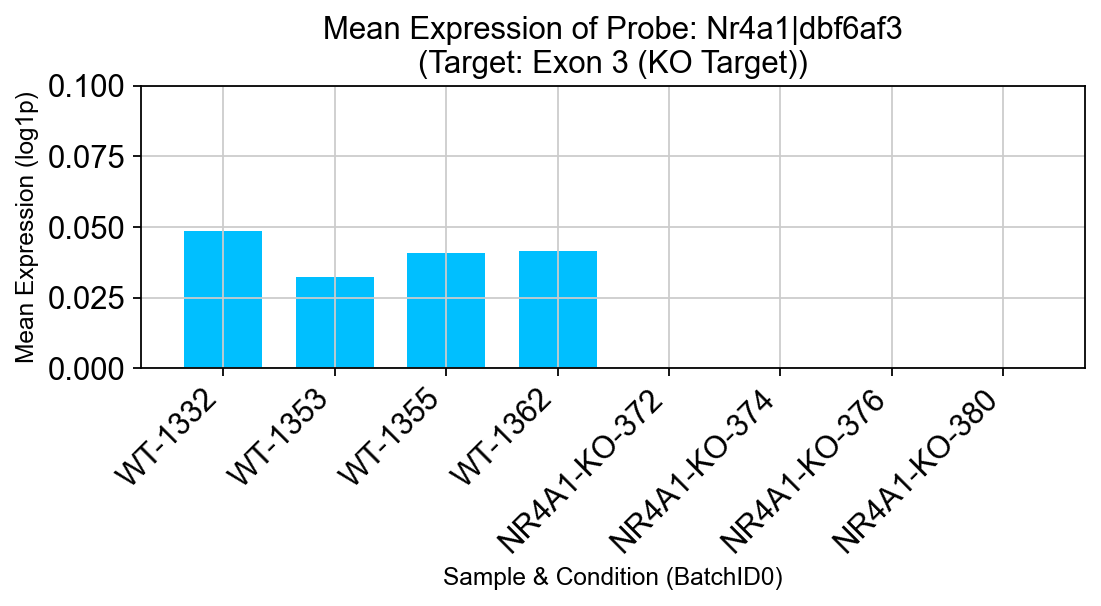

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def batch_sortkey(bid):
    bid = str(bid)
    cond = bid.split('-')[0]
    sid = int(bid.split('-')[-1])
    cond_order = 0 if 'WT' in cond else 1
    return (cond_order, sid)

batchid0_order = sorted(df_long['BatchID0'].unique(), key=batch_sortkey)

for probe_id in nr4a1_probe_ids:
    df_plot = df_long[df_long['probe_id'] == probe_id].copy()
    df_plot['log1p_expression'] = np.log1p(df_plot['expression'])
    mean_expr = df_plot.groupby('BatchID0')['log1p_expression'].mean().reindex(batchid0_order)
    
    # Build a color list: blue for WT, red for KO
    colors = []
    for bid in mean_expr.index:
        if str(bid).startswith("WT"):
            colors.append("deepskyblue")
        else:
            colors.append("red")
    
    plt.figure(figsize=(7, 4))
    plt.bar(mean_expr.index, mean_expr.values, color=colors, width=0.7)
    biological_meaning = exon_mapping.get(probe_id, "Unknown Exon")
    plt.title(f"Mean Expression of Probe: {probe_id}\n(Target: {biological_meaning})", fontsize=14)
    plt.xlabel("Sample & Condition (BatchID0)", fontsize=11)
    plt.ylabel("Mean Expression (log1p)", fontsize=11)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 0.1)
    plt.tight_layout()
    plt.savefig(f'exon_analysis_mean_{biological_meaning}.svg')
    plt.show()

In [13]:
adata

AnnData object with n_obs × n_vars = 110348 × 16149
    obs: 'cell_type', 'batch_id', 'cluster', 'BatchID0', 'CellType0', 'Condition', 'SubCellType', 'leiden_global_1.0', 'sample_id2'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden_global_1.0', 'leiden_global_1.0_colors', 'CellType0_colors', 'SubCellType_colors', 'sample_id2_colors'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

C:\Users\ssromerogon\AppData\Local\Temp\ipykernel_59592\3144799801.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_expr = df.groupby('BatchID0')['Nr4a1'].mean().reset_index()


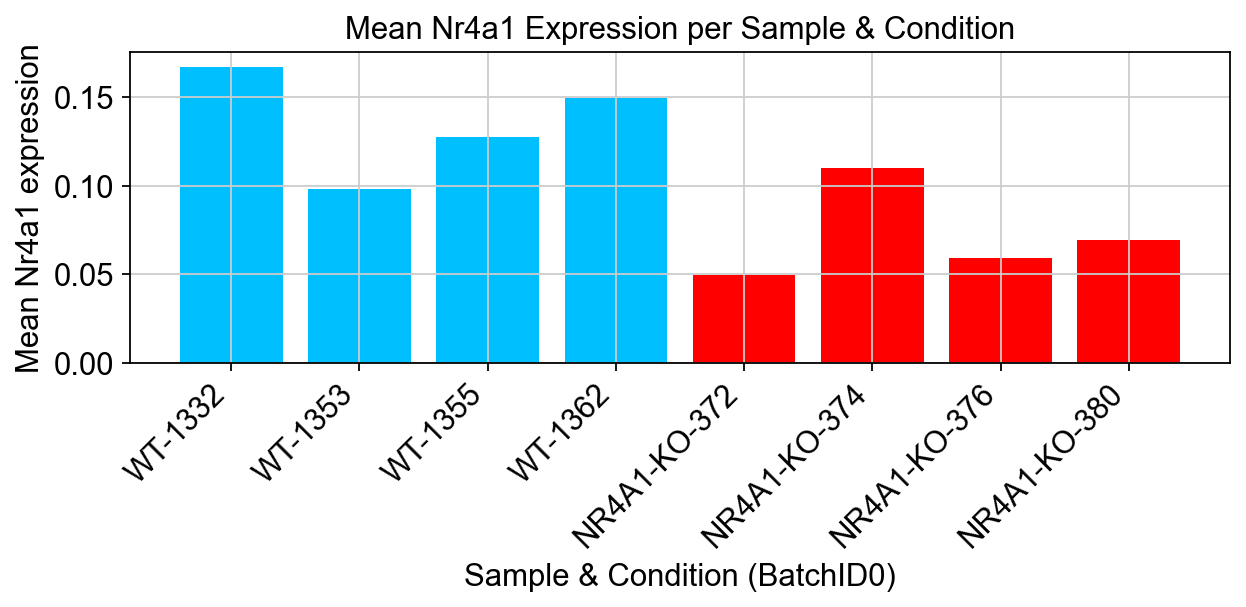

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract data
df = adata.obs[['BatchID0']].copy()
df['Nr4a1'] = adata[:, 'Nr4a1'].X.toarray().flatten() if not isinstance(adata[:, 'Nr4a1'].X, np.ndarray) else adata[:, 'Nr4a1'].X.flatten()
mean_expr = df.groupby('BatchID0')['Nr4a1'].mean().reset_index()

# Assign KO/WT from BatchID0 string
mean_expr['condition'] = mean_expr['BatchID0'].apply(lambda x: 'WT' if str(x).startswith("WT") else 'KO')

# Make the explicit WT/KO/sid order
def batch_sortkey(bid):
    bid = str(bid)
    cond = bid.split('-')[0]
    sid = int(bid.split('-')[-1])
    cond_order = 0 if 'WT' in cond else 1
    return (cond_order, sid)

# Get the correct order
batchid0_order = sorted(mean_expr['BatchID0'], key=batch_sortkey)
mean_expr = mean_expr.set_index('BatchID0').reindex(batchid0_order).reset_index()

# Build color list
colors = ['deepskyblue' if c == 'WT' else 'red' for c in mean_expr['condition']]

plt.figure(figsize=(8, 4))
plt.bar(mean_expr['BatchID0'], mean_expr['Nr4a1'], color=colors)
plt.ylabel('Mean Nr4a1 expression')
plt.xlabel('Sample & Condition (BatchID0)')
plt.title('Mean Nr4a1 Expression per Sample & Condition')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

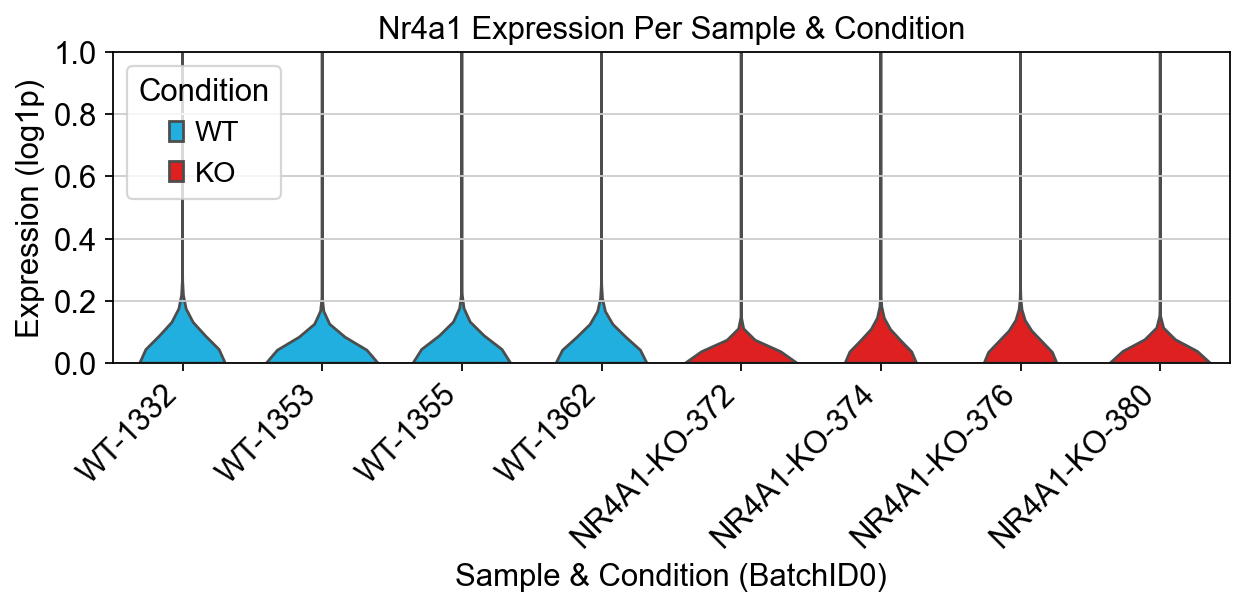

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# The 'batch_sortkey', as before
def batch_sortkey(bid):
    bid = str(bid)
    cond = bid.split('-')[0]
    sid = int(bid.split('-')[-1])
    cond_order = 0 if 'WT' in cond else 1
    return (cond_order, sid)

# X-axis order as in all your plots
batchid0_order = sorted(adata.obs['BatchID0'].unique(), key=batch_sortkey)

# Build dataframe with cell-level expression and BatchID0
df = adata.obs[['BatchID0']].copy()
df['Nr4a1'] = (
    adata[:, 'Nr4a1'].X.toarray().flatten()
    if not isinstance(adata[:, 'Nr4a1'].X, np.ndarray)
    else adata[:, 'Nr4a1'].X.flatten()
)
df['condition'] = df['BatchID0'].apply(lambda x: 'WT' if str(x).startswith("WT") else "KO")

plt.figure(figsize=(8, 4))
sns.violinplot(
    data=df,
    x='BatchID0',
    y='Nr4a1',
    hue='condition',
    order=batchid0_order,
    palette={'WT': 'deepskyblue', 'KO': 'red'},
    cut=0,
    inner='box'
)
plt.title("Nr4a1 Expression Per Sample & Condition")
plt.xlabel("Sample & Condition (BatchID0)")
plt.ylabel("Expression (log1p)")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)     # Set y limit if desired
plt.tight_layout()
plt.legend(title='Condition')
plt.show()
